<a href="https://colab.research.google.com/github/camelliatea/dicoding-image-classification/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Klasifikasi Gambar: Parasite Classification
- **Nama:** Elita Camellia
- **Email:** elita.camellia@binus.ac.id
- **ID Dicoding:** elcamelliaa
- **Sumber Dataset:** [Parasite Dataset by Ahmed Al-Rufai](https://www.kaggle.com/datasets/ahmedxc4/parasite-dataset)
    
    **Original Dataset**: Li, Sen; Zhang, Yang (2020), “Microscopic Images of Parasites Species ”, Mendeley Data, V3, doi: 10.17632/38jtn4nzs6.3


## Import Semua Packages/Library yang Digunakan

In [ ]:
# Import libraries umum
import os, shutil
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
from PIL import Image

# Import libraries untuk menampilkan visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries untuk pembuatan dan evaluasi model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# Menampilkan versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [ ]:
# Import modul untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"elitacamellia","key":"eef2b9283a773f9cdc354429dd243863"}'}

In [ ]:
# Membuat direktori .kaggle di HOME
!mkdir -p ~/.kaggle

# Menyalin file ke lokasi yang diharapkan oleh Kaggle API
!cp kaggle.json ~/.kaggle/

# Mengubah permission
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download dataset
!kaggle datasets download -d ahmedxc4/parasite-dataset

# Ekstrak file ZIP ke folder
!unzip parasite-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: parasite-dataset/Trichomonad/a75_79.jpg  
  inflating: parasite-dataset/Trichomonad/a75_8.jpg  
  inflating: parasite-dataset/Trichomonad/a75_80.jpg  
  inflating: parasite-dataset/Trichomonad/a75_81.jpg  
  inflating: parasite-dataset/Trichomonad/a75_82.jpg  
  inflating: parasite-dataset/Trichomonad/a75_83.jpg  
  inflating: parasite-dataset/Trichomonad/a75_84.jpg  
  inflating: parasite-dataset/Trichomonad/a75_85.jpg  
  inflating: parasite-dataset/Trichomonad/a75_86.jpg  
  inflating: parasite-dataset/Trichomonad/a75_87.jpg  
  inflating: parasite-dataset/Trichomonad/a75_88.jpg  
  inflating: parasite-dataset/Trichomonad/a75_89.jpg  
  inflating: parasite-dataset/Trichomonad/a75_9.jpg  
  inflating: parasite-dataset/Trichomonad/a76_0.jpg  
  inflating: parasite-dataset/Trichomonad/a76_1.jpg  
  inflating: parasite-dataset/Trichomonad/a76_10.jpg  
  inflating: parasite-dataset/Trichomonad/a76_11.jpg  
  inflating: paras

### Direktori Untuk Gabungan Data Train dan Data Test

In [ ]:
# Direktori awal
parasite_dir = 'parasite-dataset/'

# Membuat direktori untuk dataset gabungan setiap kelas
combined_dir = 'parasite/dataset'
os.makedirs(combined_dir, exist_ok=True)

# Menggabungkan semua data dalam tiap kelas ke direktori dataset gabungan
for category in os.listdir(parasite_dir):
  category_dir = os.path.join(parasite_dir, category)
  if os.path.isdir(category_dir):
    shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

### Plot Gambar Sampel Untuk Semua Kelas

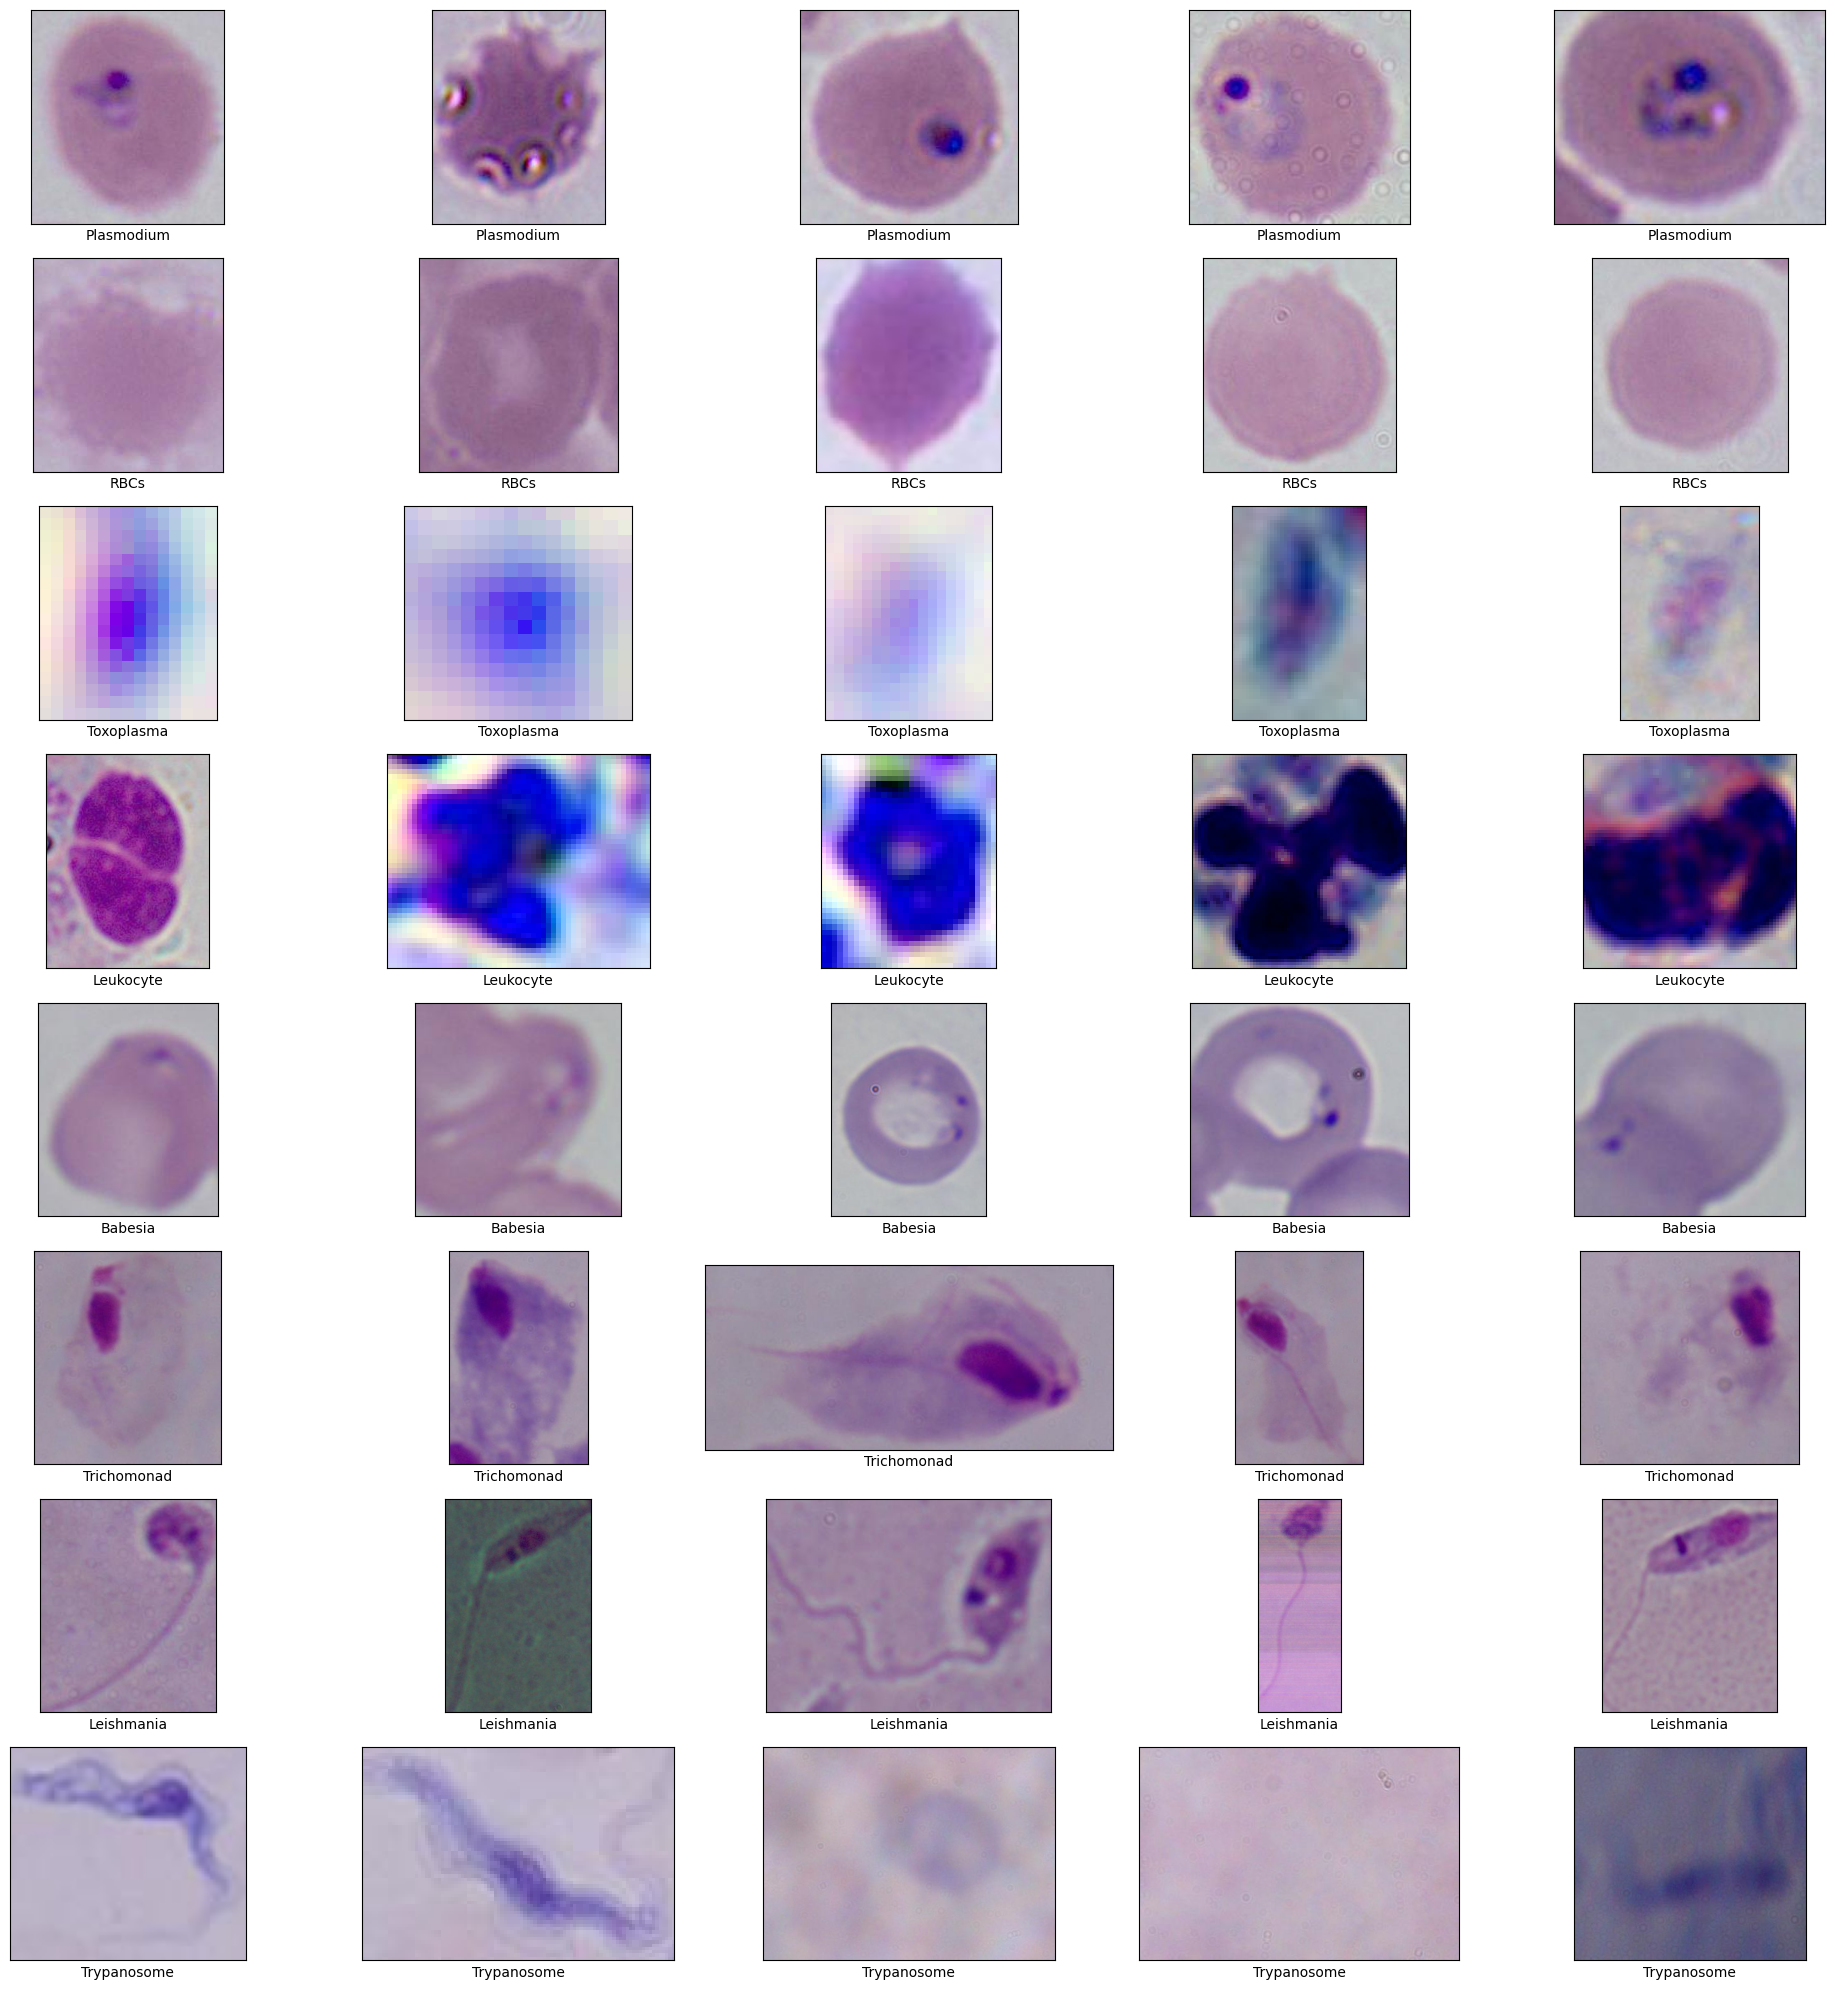

In [ ]:
# Membuat dictionary untuk menyimpan daftar gambar setiap kelas
parasite_image = {}
path_sub = os.path.join('parasite', 'dataset')

# Mengisi dictionary
for i in os.listdir(path_sub):
  parasite_image[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan 5 gambar secara acak dari masing-masing kelas dalam dataset
fig, axs = plt.subplots(len(parasite_image.keys()), 5, figsize=(20, 20))

for i, class_name in enumerate(os.listdir(path_sub)):
  images = np.random.choice(parasite_image[class_name], 5, replace=False)

  for j, image_name in enumerate(images):
    img_path = os.path.join(path_sub, class_name, image_name)
    img = Image.open(img_path).convert('RGB')  # Konversi menjadi format RGB
    axs[i, j].imshow(img)
    axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()


Insight:

Dari sampel di atas, terlihat bahwa setiap kelas memiliki resolusi yang bervariasi (tidak seragam).

### Plot Distribusi Gambar di Seluruh Kelas

In [ ]:
mypath = 'parasite/dataset/'
file_name = []
labels = []
full_path = []

# Mengumpulkan semua file dan labelnya dari dataset gabungan
for path, subdirs, files in os.walk(mypath):
  for name in files:
    full_path.append(os.path.join(path, name))
    labels.append(os.path.basename(path))
    file_name.append(name)

# Membuat dataframe dari data gambar
df = pd.DataFrame({
    'path': full_path,
    'file_name': file_name,
    'labels': labels
})

# Menampilkan jumlah gambar setiap kelas
df.groupby(['labels']).size()

,0
labels,
Babesia,1173
Leishmania,2701
Leukocyte,1376
Plasmodium,843
RBCs,8995
Toxoplasma,6691
Trichomonad,10134
Trypanosome,2385


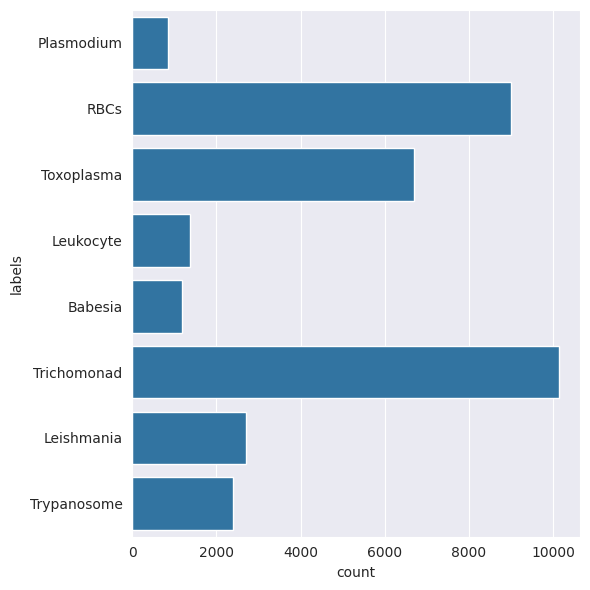

In [ ]:
# Plot distribusi jumlah gambar setiap kelas
plt.figure(figsize = (6,6))
sns.set_style('darkgrid')
sns.countplot(data=df, y='labels')
plt.tight_layout()
plt.show()

 Insight:

 Berdasarkan visualisasi, terlihat bahwa persebaran data dalam dataset sangat bervariasi. Kelas dengan jumlah data terbanyak adalah Trichomonad dengan 10134 sampel, sedangkan kelas dengan jumlah data paling sedikit adalah Plasmodium dengan hanya 843 sampel. Dalam kasus ini, hanya tiga kelas yang akan digunakan, yaitu Trichomonad, RBCs, dan Toxoplasma, yang masing-masing memiliki lebih dari 5000 sampel. Pemilihan kelas ini dilakukan untuk memastikan bahwa jumlah data untuk setiap kelas tercukupi sehingga model dapat menghasilkan kinerja yang optimal.

## Data Preprocessing

### Split Dataset

In [ ]:
selected_labels = ['Trichomonad', 'RBCs', 'Toxoplasma']

final_df = df[df['labels'].apply(lambda x: x in selected_labels)]

final_df.groupby(['labels']).size()

,0
labels,
RBCs,8995
Toxoplasma,6691
Trichomonad,10134


In [ ]:
# Mengambil data path (X) dan label (y)
X = final_df['path']
y = final_df['labels']

# Split data 80% train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=300)

# Membuat dataframe untuk masing-masing set
train_df = pd.DataFrame({'path': X_train, 'labels': y_train, 'set': 'train'})
test_df = pd.DataFrame({'path': X_test, 'labels': y_test, 'set': 'test'})

# Menggabungkan seluruh set
all_df = pd.concat([train_df, test_df], ignore_index=True)

print(all_df.groupby(['set', 'labels']).size())
print(all_df.sample(5))

set    labels     
test   RBCs           1748
       Toxoplasma     1371
       Trichomonad    2045
train  RBCs           7247
       Toxoplasma     5320
       Trichomonad    8089
dtype: int64
                                               path       labels    set
18702     parasite/dataset/Toxoplasma/1_0011229.jpg   Toxoplasma  train
14419        parasite/dataset/Trichomonad/a73_5.jpg  Trichomonad  train
2878       parasite/dataset/Trichomonad/a101_20.jpg  Trichomonad  train
2608   parasite/dataset/Toxoplasma/toxo_0001726.png   Toxoplasma  train
10817     parasite/dataset/RBCs/4334mcell_train.jpg         RBCs  train


In [ ]:
# Memanggil dataset asli
datasource_path = 'parasite/dataset/'

# Membuat variabel Dataset
dataset_path = 'Dataset-Final'

for index, row in tq(all_df.iterrows()):
  # Memdeteksi filepath
  file_path = row['path']

  if os.path.exists(file_path) == False:
    file_path = os.path.join(datasource_path, row['labels'], row['image'].split('.')[0])

  # Membuat direktori tujuan folder
  if os.path.exists(os.path.join(dataset_path, row['set'], row['labels'])) == False:
    os.makedirs(os.path.join(dataset_path, row['set'], row['labels']))

  # Menentukan tujuan file
  destination_file_name = file_path.split('/')[-1]
  file_destination = os.path.join(dataset_path, row['set'], row['labels'], destination_file_name)

  # Menyalin file dari sumber ke tujuan
  if os.path.exists(file_destination) == False:
    shutil.copy2(file_path, file_destination)

0it [00:00, ?it/s]

### Data Augmentation and Normalization

In [ ]:
# Fungsi untuk menghitung jumlah gambar setiap kelas di dalam folder training dan testing
def images_in_dataset(train_dir, test_dir, class_labels):
  counts = {}

  for label in class_labels:
    train_path = os.path.join(train_dir, label)
    test_path = os.path.join(test_dir, label)

    if os.path.exists(train_path):
      counts[f'train_{label.lower()}'] = len(os.listdir(train_path))
    else: counts[f'{label.lower()}'] = 0

    if os.path.exists(test_path):
      counts [f'test_{label.lower()}'] = len(os.listdir(test_path))
    else: counts[f'{label.lower()}'] = 0

  return counts

# Direktori data
TRAIN_DIR = 'Dataset-Final/train/'
TEST_DIR = 'Dataset-Final/test/'
labels = ['RBCs', 'Toxoplasma', 'Trichomonad']

image_counts = images_in_dataset(TRAIN_DIR, TEST_DIR, labels)

for key, value in image_counts.items():
  print(f"Total number of {key.replace('_', ' ')} images: {value}")


Total number of train rbcs images: 7247
Total number of test rbcs images: 1748
Total number of train toxoplasma images: 5320
Total number of test toxoplasma images: 1371
Total number of train trichomonad images: 8089
Total number of test trichomonad images: 2045


In [ ]:
# Membuat objek untuk normalisasi dan data augmentasi pada training
datagen = ImageDataGenerator(
    rescale = 1./255,           # normalisasi ke rentang [0, 1]
    rotation_range = 15,        # rotasi gambar
    zoom_range = 0.1,           # perbesar atau perkecil gambar secara acak hingga 20%
    fill_mode = 'nearest',      # mengisi area kosong hasil transformasi dengan nilai pixel terdekat
    validation_split = 0.2
)

# Membuat objek untuk normalisasi pada validasi dan testing
test_datagen = ImageDataGenerator(rescale = 1./255)

# Generator untuk masing-masing set
train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size = (128, 128),
    batch_size = 32,
    color_mode = "rgb",
    class_mode = 'categorical',
    subset = 'training',
    shuffle = True
)

validation_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size = (128, 128),
    batch_size = 32,
    color_mode = "rgb",
    class_mode = 'categorical',
    subset = 'validation',
    shuffle = False
)

testing_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size = (128, 128),
    batch_size = 1,
    color_mode = "rgb",
    class_mode = 'categorical',
    shuffle = False
)

Found 16526 images belonging to 3 classes.
Found 4130 images belonging to 3 classes.
Found 5164 images belonging to 3 classes.


## Modelling

In [ ]:
# Init sequential model
model = Sequential()

# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu', input_shape = (128, 128, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D(2, 2))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model.add(Conv2D(64, (4, 4), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2, 2))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model.add(Conv2D(64, (5, 5), padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2, 2))

# Flatten, Dense, dan Dropout layer
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

# Final Dense layer
model.add(Dense(3, activation = 'softmax'))

# Compile model
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.000001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
    )

# Summary
print(model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,048,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,219,459 (4.65 MB)

 Trainable params: 1,219,075 (4.65 MB)

 Non-trainable params: 384 (1.50 KB)

None


In [ ]:
class_counts = train_generator.classes
class_totals = dict(zip(*np.unique(class_counts, return_counts = True))) # Menghitung jumlah gambar per kelas
total_samples = sum(class_totals.values())
num_classes = len(class_totals)

class_weights = {
    i: (1.0 / class_totals[i] * (total_samples / num_classes))
    for i in class_totals
}

In [ ]:
# Mengukur waktu eksekusi
%time

# Menghentikan training jika tidak ada perbaikan pada validation loss dalam 5x epoch
early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    restore_best_weights = True # Mengembalikan bobot model terbaik
    )

# Melatih model
history = model.fit(
    train_generator,
    epochs = 10,
    batch_size = 64,
    validation_data = validation_generator,
    class_weight = class_weights,
    callbacks = [early_stop]
)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 111s 198ms/step - accuracy: 0.6263 - loss: 0.9115 - val_accuracy: 0.8070 - val_loss: 0.5839
Epoch 2/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 93s 179ms/step - accuracy: 0.9352 - loss: 0.1791 - val_accuracy: 0.9528 - val_loss: 0.2445
Epoch 3/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 94s 182ms/step - accuracy: 0.9683 - loss: 0.0961 - val_accuracy: 0.9530 - val_loss: 0.2425
Epoch 4/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 101s 196ms/step - accuracy: 0.9827 - loss: 0.0640 - val_accuracy: 0.9542 - val_loss: 0.2563
Epoch 5/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 134s 180ms/step - accuracy: 0.9912 - loss: 0.0401 - val_accuracy: 0.9535 - val_loss: 0.2811
Epoch 6/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 92s 178ms/step - accuracy: 0.9910 - loss: 0.0321 - val_accuracy: 0.9540 - val_loss: 0.2909
Epoch 7/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 94s 182ms/step - accuracy: 0.9886 - loss: 0.0332 - val_accuracy: 0.9547 - val_loss: 0.3086
Epoch 8/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 93s 180ms/step - accuracy: 0.9941 - loss

## Evaluasi dan Visualisasi

In [ ]:
accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(len(accuracy))

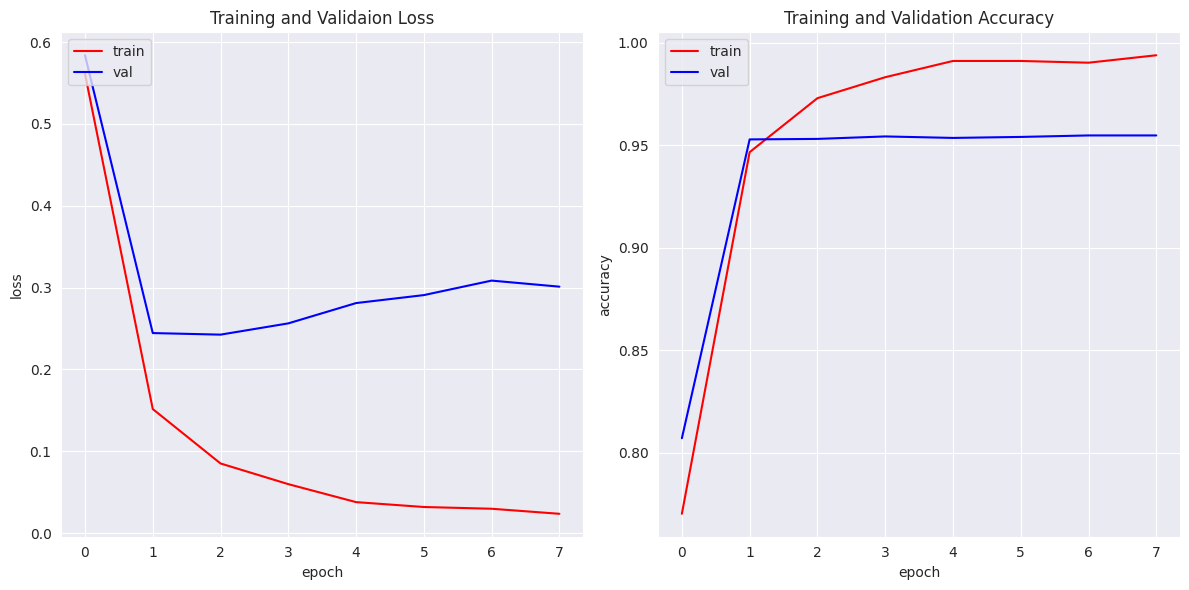

In [ ]:
plt.figure(figsize = (12, 6))

# Plot Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'r')
plt.plot(epochs, validation_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')

# Plot Traing and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'r')
plt.plot(epochs, validation_accuracy, 'b')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

Insight:

- Training dan Validation accuracy meningkat tajam dari epoch 0 ke epoch 1, namun tidak mengalami peningkatan signifikan setelahnya. Di akhir epoch, Training accuracy mencapai ~99% sementara Validation accuracy sekitar ~95%.
- Training loss menunjukkan penurunan yang konsisten dari epoch ke-0 hingga epoch ke-7, yang menandakan bahwa model semakin baik dalam mempelajari data pelatihan. Sementara itu, Validation loss mengalami penurunan hingga epoch ke-2, namun mulai meningkat setelahnya dan tidak menunjukkan perbaikan yang berarti hingga epoch ke-7 (5x epoch). Maka dari itu, pelatihan dihentikan sesuai dengan mekanisme early stopping untuk mencegah penurunan performa model.

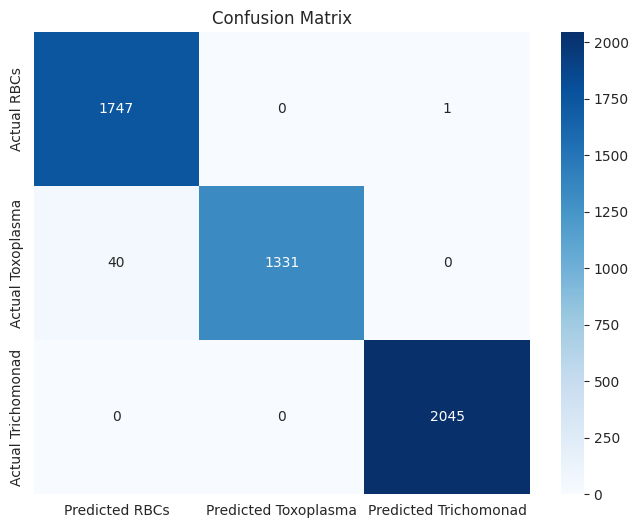


Classification Report:

              precision    recall  f1-score   support

        RBCs     0.9776    0.9994    0.9884      1748
  Toxoplasma     1.0000    0.9708    0.9852      1371
 Trichomonad     0.9995    1.0000    0.9998      2045

    accuracy                         0.9921      5164
   macro avg     0.9924    0.9901    0.9911      5164
weighted avg     0.9922    0.9921    0.9920      5164



In [ ]:
testing_generator.reset()

# Predict
preds = model.predict(testing_generator, verbose = 0)
preds_class = np.argmax(preds, axis=1)

labels = list(testing_generator.class_indices.keys())

# Confusion Matrix
cm = pd.DataFrame(
    data = confusion_matrix(testing_generator.classes, preds_class),
    index = [f'Actual {label}' for label in labels],
    columns = [f'Predicted {label}' for label in labels]
)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print('\nClassification Report:\n')
print(classification_report(
    y_true = testing_generator.classes,
    y_pred = preds_class,
    target_names = labels,
    digits=4)
)

Insight:

- Accuracy model mencapai ~99% yang menunjukkan bahwa model memiliki performa sangat tinggi dan stabil dalam mengklasifikasikan tiga kelas, yakni RBCs, Toxoplasma, dan Trichomonad.
- Toxoplasma memiliki precision tertinggi yang menunjukkan bahwa seluruh prediksi sebagai Toxoplasma benar. Namun, recall-nya merupakan yang terendah di antara dua kelas lainnya karena terdapat 40 sampel Toxoplasma yang salah diklasifikasikan sebagai RBCs.
- Trichomonad menunjukkan performa nyaris sempurna di semua metrik dengan precision dan recall yang hampir identik dan sangat tinggi.
- RBCs memiliki recall yang sangat tinggi yang menunjukkan bahwa hampir semua sampel RBCs berhasil dikenali dengan benar. Namun, precision-nya sedikit lebih rendah karena adanya 1 sampel RBCs yang salah diklasifikasikan sebagai Trichomonad, serta 40 sampel Toxoplasma yang keliru diprediksi sebagai RBCs.

## Konversi Model

In [ ]:
# Buat direktori struktur folder submission
os.makedirs('submission/tfjs_model', exist_ok=True)
os.makedirs('submission/tflite', exist_ok=True)
os.makedirs('submission/saved_model', exist_ok=True)

In [ ]:
# 1. Menyimpan model dalam .h5 untuk TFJS
model.save('model.h5')

In [ ]:
# 2. Menyimpan model dalam format SavedModel
tf.saved_model.save(model, 'submission/saved_model')

In [ ]:
# 3. Menyimpan model dalam format TF-Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Menyimpan model TF-Lite ke file
with open('submission/tflite/model.tflite', 'wb') as f:
  f.write(tflite_model)

# Menyimpan label
with open('submission/tflite/label.txt', 'w') as f:
  f.write('RBCs\nToxoplasma\nTrichomonad')

Saved artifact at '/tmp/tmpsr1b_4_x'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  135133990986256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135133990987216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135133990989328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135133990990672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135133990990480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135133990988368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135133990991248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135133990992016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135133990993552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135133990992208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13513399099163

In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
# 4. Konversi model .h5 ke format TFjs
!tensorflowjs_converter --input_format=keras model.h5 submission/tfjs_model

2025-04-20 18:12:44.493280: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745172764.513008    8206 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745172764.519035    8206 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


## Inference (Optional)

In [ ]:
labels = ['RBCs', 'Toxoplasma', 'Trichomonad']
model = tf.saved_model.load('submission/saved_model')
infer = model.signatures['serving_default']

# Fungsi Inference
def predict_images (filename):
  # Memuat dan memproses gambar
  img = tf.io.read_file(filename)

  ext = os.path.splitext(filename)[1].lower()
  if ext in ['.jpg', '.jpeg']:
      img = tf.io.decode_jpeg(img, channels=3)
  elif ext == '.png':
      img = tf.io.decode_png(img, channels=3)
  else:
      raise ValueError(f'Unsupported image format: {ext}')

  img = tf.image.resize(img, size=(128, 128))
  img = tf.cast(img, tf.float32) / 255.0
  img = tf.expand_dims(img, axis = 0)

  # Inference
  result = infer(img)
  probs = tf.nn.softmax(result['output_0'][0])

  pred_idx = tf.argmax(probs).numpy()
  pred_label = labels[pred_idx]

  predicts = f'\n{os.path.basename(filename)}: {pred_label}'

  plt.imshow(tf.squeeze(img))
  plt.axis('off')
  plt.title(predicts, fontsize = 14)
  plt.show()

Saving pics.png to pics (1).png


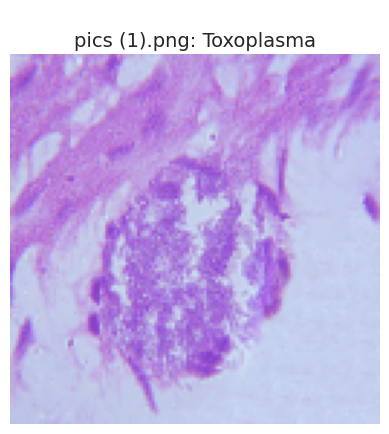

In [ ]:
from google.colab import files
img_uploaded = files.upload()

for filename in img_uploaded.keys():
  predict_images(filename)

Insight:

Model berhasil memprediksi foto baru (pics.png) sebagai Toxoplasma.


> Referensi Foto: Ismael, I., Alaa, M., Swelum, A., & Nassan, M. (2016). Development of improved preventive and treatment strategies for controlling toxoplasmosis in Saudi Arabia. American Journal of Infectious Diseases, 12(1), 50-56. https://doi.org/10.3844/ajidsp.2016.50.56




In [ ]:
# Menentukan nama notebook dan folder tujuan
notebook_name = 'Submission_Akhir.ipynb'
source_folder = '/content/drive/MyDrive/Colab Notebooks/'
destination_folder = '/content/submission/'

# Menyimpan notebook ke folder submission
shutil.copy(os.path.join(source_folder, notebook_name), os.path.join(destination_folder, notebook_name))

'/content/submission/Submission_Akhir.ipynb'

In [ ]:
shutil.make_archive('submission', 'zip', 'submission')
files.download('submission.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>